## Model selection - Zillow dataset forecasting

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

%config InlineBackend.figure_format = 'svg'

### Read data

In [34]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [35]:
df = pd.read_csv('../data/zillow-california.csv', parse_dates=['Date'])

In [36]:
sellprice = df['MedianSoldPrice_AllHomes.California']
sellprice.index = pd.DatetimeIndex(df['Date'])
sellprice.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianSoldPrice_AllHomes.California, dtype: float64

In [37]:
sellprice_not_na = sellprice[~sellprice.isna()]
sellprice_not_na.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianSoldPrice_AllHomes.California, dtype: float64

### Differencing

### Trend Differencing
#### 1-time trend differencing

In [38]:
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

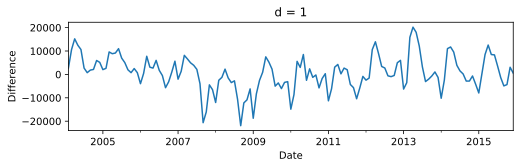

In [39]:
plt.figure(figsize=(8, 2))
fig = sellprice_d1.plot()
plt.ylabel('Difference')
plt.title('d = 1')
plt.show()

In [40]:
plt.savefig('d1-differencing', dpi=1000)

<Figure size 432x288 with 0 Axes>

In [41]:
adf_test(sellprice_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 2-time trend differencing

In [42]:
sellprice_d2 = pd.Series(np.diff(sellprice_not_na.values, n=2),
                           index=sellprice_not_na.index[2:])

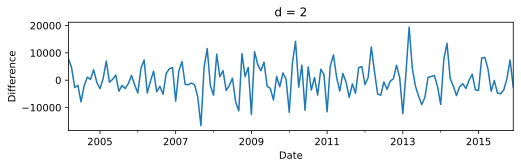

In [43]:
plt.figure(figsize=(8, 2))
fig = sellprice_d2.plot()
plt.ylabel('Difference')
plt.title('d = 2')
plt.show()

In [44]:
plt.savefig('d2-differencing', dpi=1000)

<Figure size 432x288 with 0 Axes>

In [45]:
adf_test(sellprice_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Seasonal Time Differencing
#### 1-time seasonal differencing on 1-time trend differencing

There appears to be slight seasonality with lag 12, according to the 1-time differencing line plot.

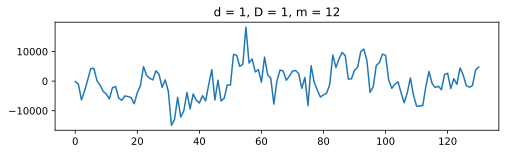

In [46]:
sellprice_d1_D1 = []
for i in range(12, len(sellprice_d1)):
    value = sellprice_d1[i] - sellprice_d1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d1_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 1, D = 1, m = 12')
plt.plot(sellprice_d1_D1) 
plt.show()

In [47]:
adf_test(sellprice_d1_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.121323
p-value                          0.236028
#Lags Used                      13.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


#### 1-time seasonal differencing on 2-time trend differencing

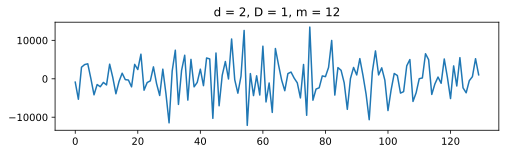

In [48]:
sellprice_d2_D1 = []
for i in range(12, len(sellprice_d2)):
    value = sellprice_d2[i] - sellprice_d2[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 1, m = 12')
plt.plot(sellprice_d2_D1) 
plt.show()

In [49]:
adf_test(sellprice_d2_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


#### 2-time seasonal differencing on 1-time trend differencing

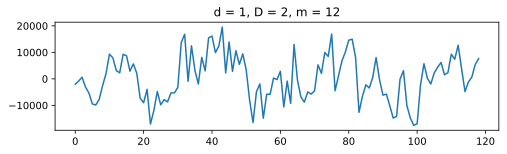

In [50]:
sellprice_d1_D2 = []
for i in range(12, len(sellprice_d1_D1)):
    value = sellprice_d1_D1[i] - sellprice_d1_D1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d1_D2.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 1, D = 2, m = 12')
plt.plot(sellprice_d1_D2) 
plt.show()

In [51]:
adf_test(sellprice_d1_D2)

Results of Dickey-Fuller Test:
Test Statistic                  -2.621665
p-value                          0.088602
#Lags Used                      13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


## Model selection with Auto-ARIMA

In [52]:
def create_training_splits(data, log=False):
    
    train_size = int(len(data) * 0.80)
    
    train = data[:train_size]
    valid = data[train_size:]
    
    # Hardcoded
    test = sellprice[sellprice.index >= pd.to_datetime('2016')] 
    
    if log: 
        return np.log(train), np.log(valid), np.log(test)
    else: 
        return train, valid, test

In [53]:
train, valid, test = create_training_splits(sellprice_not_na)

In [54]:
logtrain, logvalid, logtest = create_training_splits(sellprice_not_na, log=True)

In [55]:
fulldata = sellprice_not_na

In [56]:
logfull = np.log(fulldata)

# Univariate Log Transformed

### d = 1, D = 1

In [57]:
log_model_d1_D1 = pm.auto_arima(logtrain, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-608.710, BIC=-595.585, Fit time=0.640 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-554.393, BIC=-549.143, Fit time=0.075 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-605.739, BIC=-595.240, Fit time=0.943 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-584.396, BIC=-573.896, Fit time=0.560 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-604.697, BIC=-588.947, Fit time=1.176 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-600.551, BIC=-590.051, Fit time=0.065 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-609.149, BIC=-593.399, Fit time=2.176 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-583.165, BIC=-570.040, Fit time=0.453 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-607.876, BIC=-589.501, Fit time=1.617 seconds
Fit ARIMA: order=(1, 1, 0) s

In [58]:
log_model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 2, 12)   Log Likelihood                 310.116
Date:                            Tue, 10 Dec 2019   AIC                           -610.233
Time:                                    21:00:40   BIC                           -597.108
Sample:                                         0   HQIC                          -604.918
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.291      0.771      -0.001       0.001
ar.L1          0.6970      0.087      8.051      0.000       0.527       0.867
ma.S.L12      -0.4446      0.101     -4.398      0.000      -0.643      -0.246
ma.S.L24      -0.2000      0.116     -1.732      0.083      -0.426       0.026
sigma2         0.0001   1.75e-05      7.209      0.000    9.18e-05       0.000
===================================================================================
Ljung-Box (Q):                       31.97   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.81   Prob(JB):                         0.67
Heteroskedasticity (H):               2.37   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

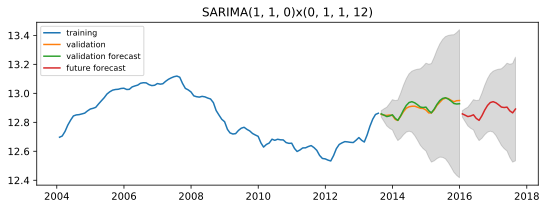

In [59]:
fc1, conf1 = log_model_d1_D1.predict(len(logvalid), return_conf_int=True, alpha=0.05)
fc2, conf2 = log_model_d1_D1.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=logvalid.index)
fc_series2 = pd.Series(fc2, index=logtest.index)

lower_series1 = pd.Series(conf1[:, 0], index=logvalid.index)
upper_series1 = pd.Series(conf1[:, 1], index=logvalid.index)
lower_series2 = pd.Series(conf2[:, 0], index=logtest.index)
upper_series2 = pd.Series(conf2[:, 1], index=logtest.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(logtrain, label='training')
plt.plot(logvalid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 0)x(0, 1, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [60]:
mse = ((fc_series1 - logvalid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

0.01


#### Transformed Back

In [61]:
mse = ((np.exp(fc_series1) - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

5640.62


### Training Model on Full Data

In [62]:
log_model_d1_D1_full = pm.auto_arima(logfull, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-802.044, BIC=-787.668, Fit time=0.935 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-727.661, BIC=-721.910, Fit time=0.029 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-794.993, BIC=-783.493, Fit time=0.570 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-773.964, BIC=-762.464, Fit time=0.940 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-794.465, BIC=-777.214, Fit time=0.840 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-786.570, BIC=-775.069, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-807.914, BIC=-790.663, Fit time=1.934 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-779.186, BIC=-764.810, Fit time=0.975 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-805.601, BIC=-785.475, Fit time=1.015 seconds
Fit ARIMA: order=(1, 1, 0) s

In [63]:
log_model_d1_D1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                 411.018
Date:                            Tue, 10 Dec 2019   AIC                           -808.035
Time:                                    21:01:01   BIC                           -787.909
Sample:                                         0   HQIC                          -799.857
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.524e-05      0.000     -0.115      0.908      -0.001       0.001
ar.L1          0.7312      0.134      5.437      0.000       0.468       0.995
ma.L1         -0.1675      0.157     -1.067      0.286      -0.475       0.140
ma.L2          0.0127      0.130      0.098      0.922      -0.243       0.268
ma.S.L12      -0.4833      0.100     -4.843      0.000      -0.679      -0.288
ma.S.L24      -0.2890      0.103     -2.796      0.005      -0.492      -0.086
sigma2         0.0001   1.22e-05      8.422      0.000    7.86e-05       0.000
===================================================================================
Ljung-Box (Q):                       50.11   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.13   Prob(JB):                         0.45
Heteroskedasticity (H):               1.08   Skew:                             0.08
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

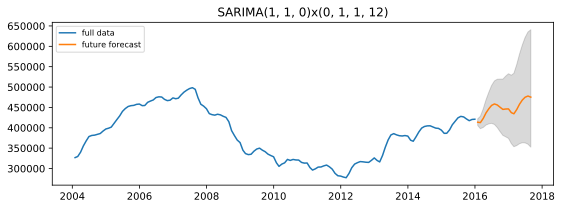

In [64]:
fc1, conf1 = log_model_d1_D1_full.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(np.exp(fc1), index=logtest.index)

lower_series1 = np.exp(pd.Series(conf1[:, 0], index=logtest.index))
upper_series1 = np.exp(pd.Series(conf1[:, 1], index=logtest.index))


# Plot
plt.figure(figsize=(9, 3))
plt.plot(np.exp(logfull), label='full data')
plt.plot(fc_series1, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 0)x(0, 1, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()